In [3]:
#!pip install scikeras


In [43]:
# =============================================================================
# Deep Neural Network Classification on the Pima Indians Diabetes Dataset
# =============================================================================
# This script demonstrates a complete pipeline for predicting diabetes presence:
# 1. Data loading and exploration from a CSV file (pima_diabetes.csv).
# 2. Data preprocessing (handling missing values, scaling).
# 3. Building and training a neural network (Keras) with scikit-learn wrapper.
# 4. Evaluation with classification report, confusion matrix, ROC curve,
#    precision-recall curve.
# 5. Advanced Visualizations:
#    - Parallel Coordinates Plot to explore feature distributions
#    - Training Loss Curve to illustrate model convergence
#    - Confusion Matrix with a "PuBu" colormap
#    - ROC and Precision-Recall curves
#    - (Optional) Permutation importance demonstration

# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

In [5]:
# Set a new visualization style: "Solarize_Light2"
# -----------------------------------------------------------------------------
plt.style.use("Solarize_Light2")
sns.set_theme(style="whitegrid", palette="deep")

In [9]:
# Data Loading and Exploration
df = pd.read_csv("/content/diabetes.csv")

In [10]:
# ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI',
#  'DiabetesPedigreeFunction','Age','Outcome']
# Where 'Outcome' = 1 indicates diabetes, 0 indicates no diabetes.

# Check for missing or zero values that might be placeholders
print("Missing values per column:\n", df.isna().sum())

Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
# Some columns like Glucose, BloodPressure, SkinThickness, Insulin, BMI
# have zeros that should be treated as missing. Let's do a simple approach:
for col in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
    df[col].replace(0, np.nan, inplace=True)
    df[col].fillna(df[col].median(), inplace=True)


<ipython-input-11-043efd43bdd8>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(0, np.nan, inplace=True)
<ipython-input-11-043efd43bdd8>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

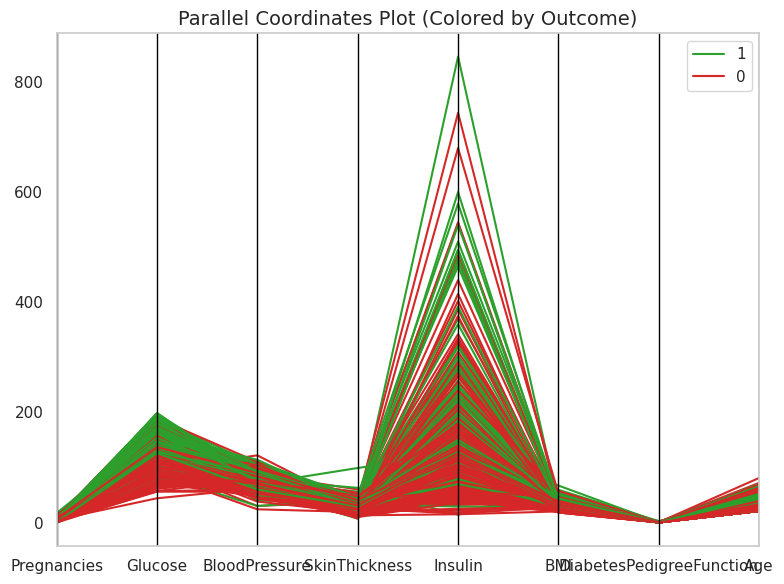

In [12]:
# Parallel Coordinates Plot to visualize data distributions
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(8,6))
# We'll rename 'Outcome' to 'class' temporarily for parallel_coordinates
df_plot = df.copy()
df_plot['Outcome'] = df_plot['Outcome'].astype(str)  # convert to str for color grouping
parallel_coordinates(df_plot, class_column='Outcome', cols=df_plot.columns[:-1], color=('#2ca02c','#d62728'))
plt.title("Parallel Coordinates Plot (Colored by Outcome)", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# -----------------------------------------------------------------------------
# Data Preprocessing
# -----------------------------------------------------------------------------
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']


In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (537, 8)
Testing set shape: (231, 8)


In [15]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [19]:
# -----------------------------------------------------------------------------
# 3. Building a Keras Model via scikit-learn Wrapper
# -----------------------------------------------------------------------------
def create_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
# Wrap the Keras model for scikit-learn
nn_clf = KerasClassifier(build_fn=create_model, epochs=30, batch_size=32, verbose=0)
nn_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

KerasClassifier(
	model=None
	build_fn=<function create_model at 0x78c2a1f49800>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=30
	class_weight=None
)

In [31]:
# -----------------------------------------------------------------------------
# Model Evaluation
# -----------------------------------------------------------------------------
y_pred = nn_clf.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       150
           1       0.66      0.51      0.57        81

    accuracy                           0.74       231
   macro avg       0.71      0.68      0.69       231
weighted avg       0.73      0.74      0.73       231



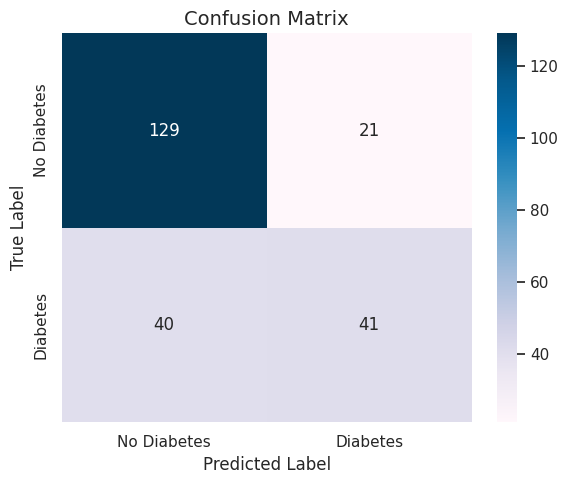

In [32]:
# -----------------------------------------------------------------------------
# 5. Visualization: Confusion Matrix (PuBu colormap)
# -----------------------------------------------------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="PuBu",
            xticklabels=["No Diabetes","Diabetes"],
            yticklabels=["No Diabetes","Diabetes"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

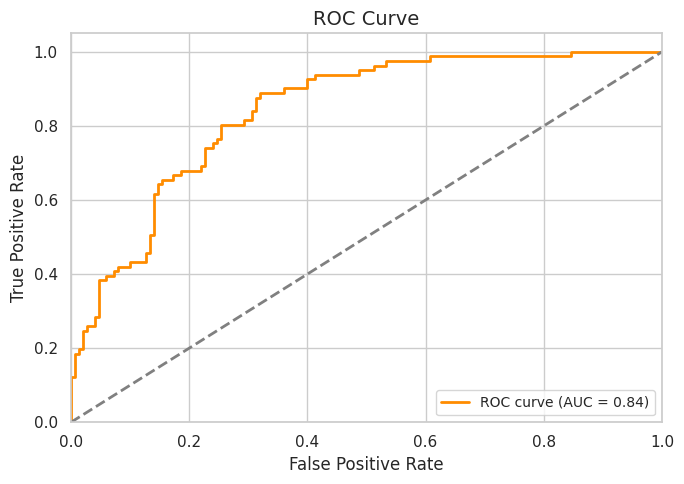

In [36]:
# -----------------------------------------------------------------------------
# 6. Visualization: ROC Curve
# -----------------------------------------------------------------------------
# Get predicted probabilities from the KerasClassifier (scikeras)
y_proba = nn_clf.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.tight_layout()
plt.show()


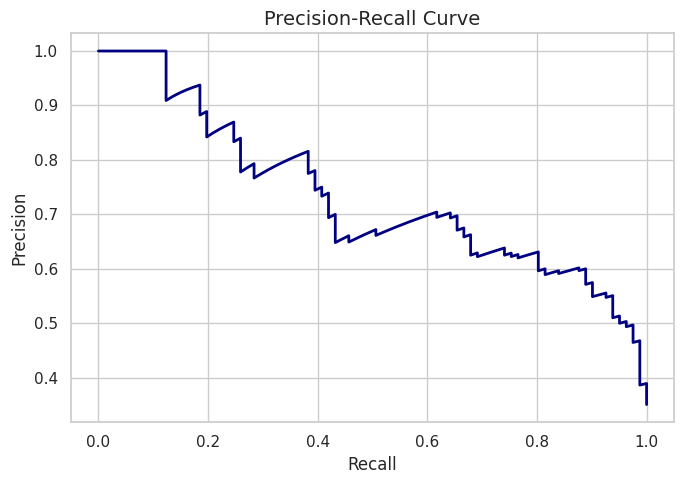

In [37]:
# -----------------------------------------------------------------------------
# 7. Visualization: Precision-Recall Curve
# -----------------------------------------------------------------------------
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='navy', lw=2)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision-Recall Curve", fontsize=14)
plt.tight_layout()
plt.show()

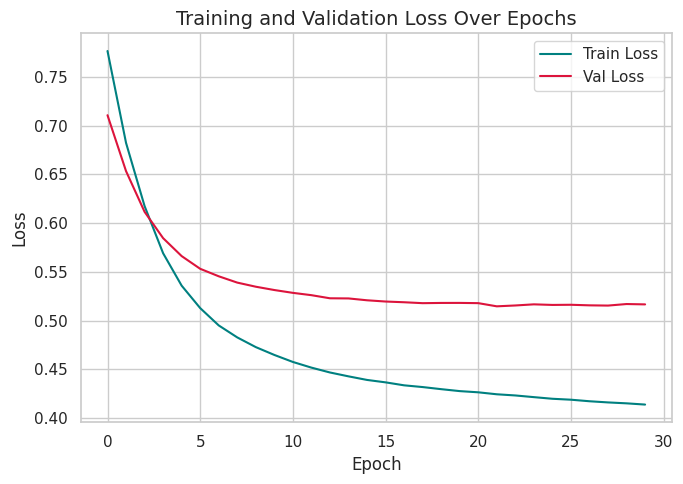

In [39]:
# Access training history
history = nn_clf_verbose.history_

# Plot the loss curves
plt.figure(figsize=(7,5))
plt.plot(history["loss"], label="Train Loss", color="teal")
plt.plot(history["val_loss"], label="Val Loss", color="crimson")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Over Epochs", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


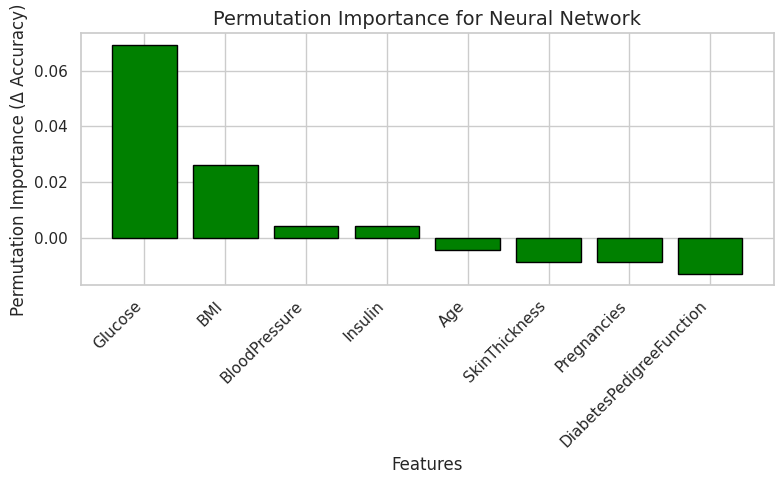

In [41]:
baseline_acc = accuracy_score(y_test, nn_clf.predict(X_test_scaled))
importances = []

for i in range(X_test_scaled.shape[1]):
    X_permuted = X_test_scaled.copy()
    np.random.shuffle(X_permuted[:, i])
    acc = accuracy_score(y_test, nn_clf.predict(X_permuted))
    importances.append(baseline_acc - acc)

# Sort and plot
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), np.array(importances)[sorted_idx], color='green', edgecolor='black')
plt.xticks(range(len(importances)), [X.columns[i] for i in sorted_idx], rotation=45, ha='right')
plt.xlabel("Features", fontsize=12)
plt.ylabel("Permutation Importance (Δ Accuracy)", fontsize=12)
plt.title("Permutation Importance for Neural Network", fontsize=14)
plt.tight_layout()
plt.show()
